<a href="https://colab.research.google.com/github/hyunicecream/ML-DL/blob/main/%EB%8B%A8%EB%B0%A9%ED%96%A5%20many%20to%20many.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Dense, Input, LSTM, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 2차원 배열의 feature 데이터로 LSTM 학습 데이터를 만든다.
def build_train_data(data, t_step, n_jump = 1):
  n_data = data.shape[0] # number of data
  n_feat = data.shape[1] # number of features

  m = np.arange(0, n_data -  t_step, n_jump)  # m = [0,1,2,3,4,5]
  x = [data[i:(i+t_step), :] for i in m]      # feature data
  y = [data[(i+1):(i+1+t_step), :] for i in m]      # target data
# y 값을 변경

  # shape을 조정한다. feautre = 3D, target = 2D
  x_data = np.reshape(np.array(x), (len(m), t_step, n_feat))
  y_target = np.reshape(np.array(y), (len(m), t_step, n_feat))
# y_target 값을 3D구조로 변경하면 된다.   
  return x_data, y_target

In [ ]:
# 시계열 데이터 (noisy sin)
#sine = np.sin(2 * np.pi * 0.03 * np.arange(1001))   # sine 곡선
sine = np.sin(2 * np.pi * 0.03 * np.arange(1001)) + np.random.random(1001) # trend & noisy sine

In [ ]:
# 데이터가 데이터프레임 형식으로 되어 있다고 생각하자. feature가 1개이고 target이 없는 데이터임.
# 미래의 sine 값을 target으로 만들어 주고, LSTM을 학습한다.
df = pd.DataFrame({'sine':sine})
df.head()

,sine
0,0.009325
1,0.954755
2,0.681666
3,1.170881
4,1.203807


In [ ]:
t_step = 20

# 학습 데이터를 생성한다.
data = np.array(df)
x_train, y_train = build_train_data(data, t_step)
x_train.shape, y_train.shape

((981, 20, 1), (981, 20, 1))

In [ ]:
n_input = 1
n_output = 1
n_hidden = 50

# LSTM 모델을 생성한다.
x_input = Input(batch_shape=(None, t_step, n_input))
x_lstm = LSTM(n_hidden, return_sequences=True)(x_input) # 2층으로 보내기 위한 return_sequences
x_lstm = LSTM(n_hidden, return_sequences=True)(x_lstm) # TimeDistributed 로 보내기 위한 return_sequences
y_output =  TimeDistributed(Dense(n_output))(x_lstm)
####### return_sequences=True(중간출력 모두 사용) 
# TimeDistributedDense(중간 출력마다 FFW를 닫아서 중간 결과과 나오도록 학습).  --> many to many로 변환

model = Model(x_input, y_output)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 20, 50)            20200     
                                                                 
 time_distributed (TimeDistr  (None, 20, 1)            51        
 ibuted)                                                         
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습한다
h = model.fit(x_train, y_train, epochs=20, batch_size=100, shuffle=True)

Epoch 1/20
10/10 [==============================] - 18s 81ms/step - loss: 0.5992
Epoch 2/20
10/10 [==============================] - 1s 80ms/step - loss: 0.3507
Epoch 3/20
10/10 [==============================] - 1s 67ms/step - loss: 0.2460
Epoch 4/20
10/10 [==============================] - 1s 69ms/step - loss: 0.2136
Epoch 5/20
10/10 [==============================] - 1s 76ms/step - loss: 0.1966
Epoch 6/20
10/10 [==============================] - 1s 65ms/step - loss: 0.1825
Epoch 7/20
10/10 [==============================] - 1s 61ms/step - loss: 0.1730
Epoch 8/20
10/10 [==============================] - 1s 73ms/step - loss: 0.1661
Epoch 9/20
10/10 [==============================] - 1s 78ms/step - loss: 0.1605
Epoch 10/20
10/10 [==============================] - 1s 74ms/step - loss: 0.1562
Epoch 11/20
10/10 [==============================] - 1s 63ms/step - loss: 0.1525
Epoch 12/20
10/10 [==============================] - 1s 68ms/step - loss: 0.1493
Epoch 13/20
10/10 [=================

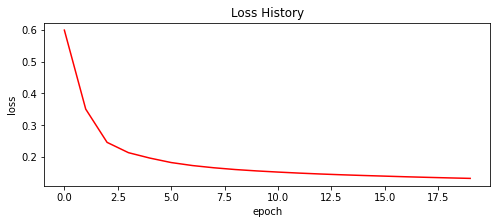

In [ ]:
# Loss history를 그린다
plt.figure(figsize=(8, 3))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
# 향후 20 기간 데이터를 예측한다. 향후 1 기간을 예측하고, 예측값을 다시 입력하여 2 기간을 예측한다.
# 이런 방식으로 20 기간까지 예측한다.
n_future = 20
n_last = 100
if len(data) > n_last:
    last_data = np.copy(data[-n_last:])  # 원 데이터의 마지막 n_last개만 그려본다
else:
    last_data = np.copy(data)

dx = np.copy(last_data)
estimated = [dx[-1][0]]
for i in range(n_future):
    # 마지막 t_step 만큼 입력데이터로 다음 값을 예측한다
    px = dx[-t_step:].reshape(1, t_step, 1)
    
    # 다음 값을 예측한다.
    y_hat = model.predict(px)[0][-1][0]
####### 첫번째 : 차원을 빼내기 위해서  두번째 : 맨뒤에를 뽑아내라 세번째: 리스트안에 있는 숫자를 뽑아내라
        
    # 예측값을 저장해 둔다
    estimated.append(y_hat)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    dx = np.insert(dx, len(dx), y_hat)

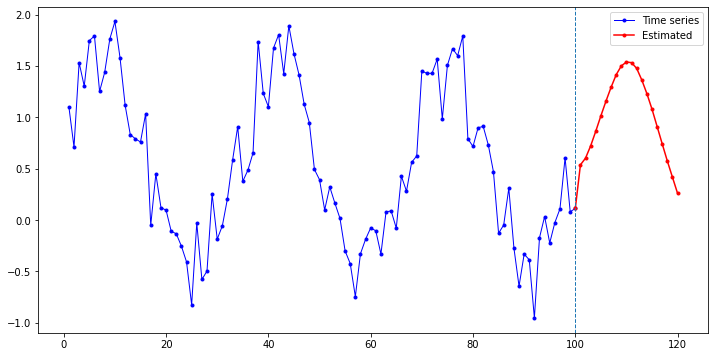

In [ ]:
# 원 시계열과 예측된 시계열을 그린다
plt.figure(figsize=(12, 6))
ax1 = np.arange(1, len(last_data) + 1)
ax2 = np.arange(len(last_data), len(last_data) + len(estimated))
plt.plot(ax1, last_data, 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)
plt.plot(ax2, estimated, 'b-o', color='red', markersize=3, label='Estimated')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()